In [ ]:
import numpy as np   
import matplotlib.pyplot as plt
from pandas import read_csv
%matplotlib inline

In [ ]:
class LARS():
  """
  X0 is the active set of features. C is the correlation matrix. LARS method for regression.
  """

  def __init__(self, X, Y):
    
    self.beta=np.zeros(np.shape(X)[1])   #initiate zero for beta
    self.MSE_history=[]

    self.X_true=X
    
    self.C=np.matmul(self.X_true.T, Y)   #initial correlations
    self.C_history=[self.C]              #history of correlations
    
    self.Y=Y
    self.Y_pred=np.zeros(np.shape(self.Y))    #initiate from zero y_pred
    self.MSE_history.append(self.MSE())
    
    self.c=np.max(abs(self.C))
    self.j=np.argmax(abs(self.C))
    self.j_list=[j]

    self.X0=self.X_true[:, j]*np.sign(self.C[self.j])
    self.s=[np.sign(self.C[self.j])]
    self.A=1.0
    self.u=self.X0
    self.a=np.matmul(self.X_true.T, self.X0)

  def MSE(self):
    """
    MSE metric to measure performance
    """
    return np.sum((self.Y-self.Y_pred)**2)/len(self.Y)

  def gamma(self, m):
    """
    This definition avoids NaN errors during computation for j in j_list
    """
    if m in self.j_list:
      return [np.inf, np.inf]
    else:
      return [(self.c - self.C[m])/(self.A - self.a[m]), (self.c + self.C[m])/(self.A + self.a[m])]

  
  def gamma_val(self):
    """
    Negative values are all set to inf
    to find min+ value
    """
    gamma_list=np.array([self.gamma(m) for m in range(np.shape(self.X_true)[1])])
    return np.where(gamma_list>0, gamma_list, np.inf)

  
  def first_step(self):  
    """
    The first step slightly differs since c needs to be found out from correlation matrix.
    In the subsequent steps, this can be bypassed using gamma.
    """
    gamma_val=self.gamma_val()
    self.j=np.argmin(gamma_val)//2
    self.j_list.append(self.j)
    k=np.argmin(gamma_val)%2
    gamma=gamma_val[self.j][k]
    
    self.Y_pred=gamma*self.X0
    self.MSE_history.append(self.MSE())

    self.beta[self.j_list[0]]=self.beta[self.j_list[0]] + gamma*self.s[0]
    
    self.C=np.matmul(self.X_true.T, self.Y-self.Y_pred)
    self.C_history.append(self.C)

    self.X0=np.append(self.X0[..., None], np.sign(self.C[self.j])*self.X_true[:, self.j][..., None], axis=1)
    self.c=self.c-gamma
    self.s.append(np.sign(self.C[self.j]))

    return None

  def step(self):
    """
    Calculates the intermediate matrices to find u and gamma. Updates beta and the active set X0
    """
    G=np.matmul(self.X0.T, self.X0)
    self.A=1/np.sqrt(np.sum(np.linalg.inv(G)))
    I=np.ones(shape=(np.shape(self.X0)[1], 1))
    self.u=np.einsum("ij, jk, kl-> il", self.X0, np.linalg.inv(G), I)*self.A
    self.u=np.reshape(self.u, np.shape(self.X0)[0])
    self.a=np.matmul(self.X_true.T, self.u)
    w=np.reshape(np.einsum("ij, jk -> ik", np.linalg.inv(G), I), np.shape(self.X0)[1])*self.A
    
    gamma_val=self.gamma_val()
    self.j=np.argmin(gamma_val)//2
    self.j_list.append(self.j)
    k=np.argmin(gamma_val)%2
    gamma=gamma_val[self.j][k]
    
    self.Y_pred=self.Y_pred+gamma*self.u
    self.MSE_history.append(self.MSE())

    for m in range(len(self.j_list)-1):
      self.beta[self.j_list[m]]=self.beta[self.j_list[m]] + gamma*self.s[m]*w[m]

    self.C=np.matmul(self.X_true.T, self.Y-self.Y_pred)
    self.C_history.append(self.C)

    self.X0=np.append(self.X0, np.sign(self.C[self.j])*self.X_true[:, self.j][..., None], axis=1)    
    self.s.append(np.sign(self.C[self.j]))
    self.c=self.c-gamma*self.A

    return None

  def reg(self):
    """
    Perform regression until all the features are exhausted
    """
    self.first_step()
    while len(self.j_list) < np.shape(self.X_true)[1]:
      L.step()
    return self.beta


In [ ]:
#Using a dataset as an example.
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
data=read_csv(url)
data =data.values
X, Y=data[:, :-1], data[:, -1]

In [ ]:
#pre-processing, mean_Y=0, mean_X=0, norm(X_j)=1
Y=Y-np.mean(Y)
for j in range(np.shape(X)[1]):
  X[:, j]=X[:, j]-np.mean(X[:, j])
  X[:, j]=X[:, j]/np.sqrt(np.sum(X[:, j]**2))

In [ ]:
L=LARS(X, Y)
L.reg()
#outputs the vector beta

array([-20.30009906,  23.52466257,   1.98067626,  15.22643095,
       -44.96555616,  60.24015272,   0.        , -69.15154164,
        56.60277355, -43.6956583 , -46.30188698,  18.97985575,
       -84.32853513])

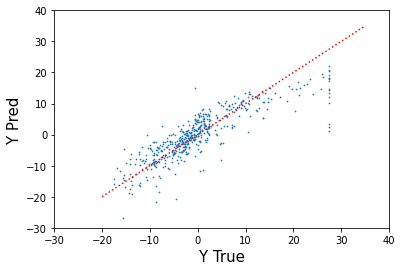

In [ ]:
plt.scatter(Y, L.Y_pred, s=0.5)
plt.xlim([-30, 40])
plt.ylim([-30, 40])
plt.plot(np.linspace(-20, 35, 100), np.linspace(-20, 35, 100), color="r", ls="dotted")
plt.xlabel("Y True", size=15)
plt.ylabel("Y Pred", size=15)
plt.show()

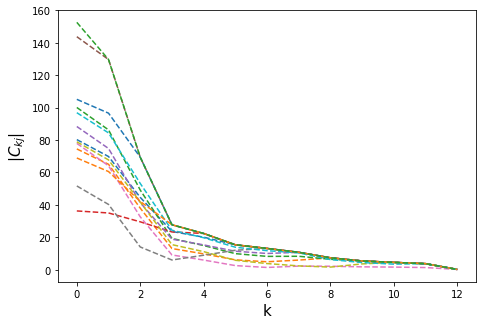

In [ ]:
Corr=np.abs(L.C_history)
plt.figure(figsize=(7.5, 5))
for j in range(np.shape(Corr)[1]):
  plt.plot(Corr[:, j], ls="dashed")
plt.xlabel("k", size=15)
plt.ylabel(r"$|C_{kj}|$", size=15)
plt.show()

In [ ]:
#All the features have the same correlations at the end of LARS.
print(np.abs(L.C_history[-1])) 

[0.15488909 0.15488909 0.15488909 0.15488909 0.15488909 0.15488909
 0.15488909 0.15488909 0.15488909 0.15488909 0.15488909 0.15488909
 0.15488909]
